In [30]:
import os
import math
import shutil
import pathlib
import random
from pathlib import Path
from PIL import Image
import numpy as np
#torch
import torch
from torch import nn
from torch import optim
#torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
#matplotlib
import matplotlib.pyplot as plt

## Create Directories

In [31]:
base_dir = r"/Users/h383kim/pytorch/AlexNet/splitted"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## Copy the images into appropriate directories

## Visualize Image

24210
/Users/h383kim/pytorch/AlexNet/splitted/train/farfalla/OIP-3dYa3sL5MZLS5qnw3OtF0gHaE8.jpeg
Height: 200
Width : 300


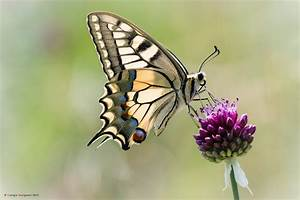

In [32]:
img_path = Path("/Users/h383kim/pytorch/AlexNet/splitted")
img_path_list = list(img_path.glob("*/*/*.jpeg"))

random_img_path = random.choice(img_path_list)
print(len(img_path_list))
print(random_img_path)

image = Image.open(random_img_path)
print(f"Height: {image.height}")
print(f"Width : {image.width}")
image

In [33]:
img_as_array = np.asarray(image)
print(img_as_array.shape)
img_as_array

(200, 300, 3)


array([[[215, 215, 205],
        [212, 212, 202],
        [208, 208, 198],
        ...,
        [218, 223, 201],
        [221, 226, 204],
        [224, 229, 207]],

       [[210, 210, 200],
        [206, 206, 196],
        [202, 202, 192],
        ...,
        [215, 220, 198],
        [218, 223, 201],
        [221, 226, 204]],

       [[205, 207, 196],
        [202, 204, 193],
        [198, 200, 189],
        ...,
        [211, 216, 194],
        [214, 219, 197],
        [217, 222, 200]],

       ...,

       [[222, 224, 203],
        [202, 204, 183],
        [213, 212, 192],
        ...,
        [213, 215, 191],
        [215, 217, 193],
        [217, 219, 195]],

       [[217, 219, 198],
        [223, 225, 204],
        [233, 232, 212],
        ...,
        [214, 216, 192],
        [217, 219, 195],
        [219, 221, 197]],

       [[215, 217, 196],
        [228, 230, 209],
        [213, 212, 192],
        ...,
        [215, 217, 193],
        [217, 219, 195],
        [219, 221, 197]]

# Run below to clear cache.

In [29]:
import gc
import torch
gc.collect()
torch.mps.empty_cache()

## Creating ImageFolder and DataLoader

In [34]:
# Device-agnostic
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"The model will run on : {DEVICE}")

The model will run on : mps


In [7]:
#DEVICE = "cpu"

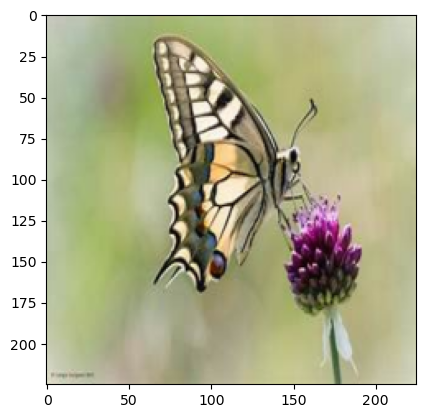

In [35]:
## Transformation
image_transform = transforms.Compose([
    transforms.Resize(size=(225,225)),
    #transforms.CenterCrop(size=(227, 227)),
    transforms.ToTensor()
])

img = image_transform(image)
img.shape
plt.imshow(img.permute(1, 2, 0))

In [36]:
train_dataset = ImageFolder(root=train_dir,
                            transform=image_transform)
val_dataset = ImageFolder(root=val_dir,
                          transform=image_transform)
test_dataset = ImageFolder(root=test_dir,
                           transform=image_transform)

BATCH_SIZE = 128

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

## Model

In [37]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch_1x1_reduc_3x3, ch_1x1_reduc_5x5,
                 out_channels_1x1, out_channels_3x3, out_channels_5x5, out_channels_pool):
        super().__init__()

        self.block_1x1 = nn.Sequential(
            # N x in_channels x W x H
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_1x1, kernel_size=(1, 1)),
            # N x out_channels_1x1, W x H
            nn.ReLU()
        )
        self.block_3x3 = nn.Sequential(
            # N x in_channels x W x H
            nn.Conv2d(in_channels=in_channels, out_channels=ch_1x1_reduc_3x3, kernel_size=(1, 1)),
            # N x ch_1x1_reduc_3x3 x W x H
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=ch_1x1_reduc_3x3, out_channels=out_channels_3x3, kernel_size=(3, 3), padding=1),
            # N x out_channels_3x3 x W x H
            nn.ReLU(inplace=True)
        )
        self.block_5x5 = nn.Sequential(
            # N x in_channels x W x H
            nn.Conv2d(in_channels=in_channels, out_channels=ch_1x1_reduc_5x5, kernel_size=(1, 1)),
            # N x ch_1x1_reduc_5x5 x W x H
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=ch_1x1_reduc_5x5, out_channels=out_channels_5x5, kernel_size=(5, 5), padding=(2, 2)),
            # N x out_channels_5x5 x W x H
            nn.ReLU(inplace=True)
        )
        self.block_pool = nn.Sequential(
            # N x in_channels x W x H
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            # N x in_channels x W x H
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_pool, kernel_size=(1, 1)),
            # N x out_channels_pool x W x H
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        block_1x1 = self.block_1x1(x)   # N x out_channels_1x1, W x H
        block_3x3 = self.block_3x3(x)   # N x out_channels_3x3 x W x H
        block_5x5 = self.block_5x5(x)   # N x out_channels_5x5 x W x H
        block_pool = self.block_pool(x) # N x out_channels_pool x W x H

        concat_output = torch.cat([block_1x1, block_3x3, block_5x5, block_pool], dim=1) 
        # N x (out_channels_1x1 + out_channels_3x3 + out_channels_5x5 + out_channels_pool) x W x H
        return concat_output

In [38]:
class AuxClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()

        # Aux 1: N x 512 x 14 x 14 (in_channels=512)
        # Aux 2: N x 528 x 14 x 14 (in_channels=528)
        #self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.avgpool = nn.AvgPool2d(kernel_size=(5,5), stride=3)
        # Aux 1: N x 512 x 4 x 4
        # Aux 2: N x 528 x 4 x 4
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=(1,1)),
            # Aux 1 / Aux 2: N x 128 x 4 x 4
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            # N x 2048
            nn.Linear(2048, 1024),
            # N x 1024
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(1024, num_classes)
            # N x 10(num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        output = self.fc(x)

        return output

In [39]:
class GoogleNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, aux_logits=True):
        super().__init__()
        # Whether to include aux_classifiers or not
        self.aux_logits = aux_logits
        self.aux1_in_channels = 512
        self.aux2_in_channels = 528

        # Instantiate the auxiliary classifiers
        if self.aux_logits and self.training:
            self.aux1 = AuxClassifier(self.aux1_in_channels, num_classes)
            self.aux2 = AuxClassifier(self.aux2_in_channels, num_classes)
        else:
            self.aux1, self.aux2 = None, None

        self.conv1 = nn.Sequential(
            # N x 3 x 225 x 225
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=2, padding=2),
            # N x 64 x 112 x 112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
            # N x 64 x 56 x 56
        )
        self.conv2 = nn.Sequential(
            # N x 64 x 56 x 56
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1)),
            # N x 64 x 56 x 56
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=(3, 3), padding=1),
            # N x 192 x 56 x 56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
            # N x 192 x 28 x 28
        )
        # N x 192 x 28 x 28
        self.inception_3a = Inception(in_channels=192, ch_1x1_reduc_3x3=96, ch_1x1_reduc_5x5=16,
                                      out_channels_1x1=64, out_channels_3x3=128, out_channels_5x5=32, out_channels_pool=32)
        # N x 256 x 28 x 28 = N x (64 + 128 + 32 + 32) x 28 x 28
        self.inception_3b = nn.Sequential(
            Inception(256, 128, 32, 128, 192, 96, 64),
            # N x 480 x 28 x 28 = N x (128 + 192 + 96 + 64)
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
            # N x 480 x 14 x 14
        )
        self.inception_4a = Inception(480, 96, 16, 192, 208, 48, 64)
        # N x 512 x 14 x 14
        self.inception_4b = Inception(512, 112, 24, 160, 224, 64, 64)
        # N x 512 x 14 x 14
        self.inception_4c = Inception(512, 128, 24, 128, 256, 64, 64)
        # N x 512 x 14 x 14
        self.inception_4d = Inception(512, 144, 32, 112, 288, 64, 64)
        # N x 528 x 14 x 14
        self.inception_4e = nn.Sequential(
            Inception(528, 160, 32, 256, 320, 128, 128),
            # N x 832 x 14 x 14
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
            # N x 832 x 7 x 7
        )
        self.inception_5a = Inception(832, 160, 32, 256, 320, 128, 128)
        # N x 832 x 7 x 7
        self.inception_5b = Inception(832, 192, 48, 384, 384, 128, 128)
        # N x 1024 x 7 x 7
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            # N x 1024 x 1 x 1
            nn.Flatten(),
            # N x 1024
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)   
            # N x 10(num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        
        x = self.inception_4a(x)
        if self.aux_logits and self.training:
            # Call the forward of auxiliary classifier 1 (i.e calculate the intermediate loss 1)
            aux1_logits = self.aux1(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.aux_logits and self.training:
            # Call the forward of auxiliary classifier 2 (i.e calculate the intermediate loss 2)
            aux2_logits = self.aux2(x)
        x = self.inception_4e(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)
        final_logits = self.fc(x)

        if self.aux_logits and self.training:
            return aux1_logits, aux2_logits, final_logits
        else:
            return final_logits
        

In [40]:
Google = GoogleNet(in_channels=3, num_classes=10, aux_logits=False).to(DEVICE)

# Loss Function
loss_fn = nn.CrossEntropyLoss().to(DEVICE)
# Optimizer
optimizer = torch.optim.SGD(params=Google.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.1)

## Train function

In [14]:
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss()):
    # Put the model into train mode
    model.train()
    train_loss, correct, train_acc = 0, 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Send X, y into the device
        X, y = X.to(DEVICE), y.to(DEVICE)

        # forward pass
        aux1_preds, aux2_preds, final_pred = model(X)

        # Calculate the loss
        grand_loss = loss_fn(final_pred, y)
        aux1_loss = loss_fn(aux1_preds, y)
        aux2_loss = loss_fn(aux2_preds, y)
        total_loss = grand_loss + 0.3*(aux1_loss + aux2_loss)
        train_loss += total_loss.item()

        # Optimizer zero_grad
        optimizer.zero_grad()

        # Loss backward
        total_loss.backward()

        #optimizer step
        optimizer.step()

        pred = torch.argmax(final_pred, dim=1)
        correct += pred.eq(y.view_as(pred)).sum().item()

    train_loss /= len(dataloader) # (Sum of train_loss for each batch) / (# of batches)
    train_acc = 100. * correct / len(dataloader.dataset)
    return train_loss, train_acc

In [41]:
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss()):
    # Put the model into train mode
    model.train()
    train_loss, correct, train_acc = 0, 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Send X, y into the device
        X, y = X.to(DEVICE), y.to(DEVICE)

        # forward pass
        preds_prod = model(X)

        # Calculate the loss
        loss = loss_fn(preds_prod, y)
        train_loss += loss.item()

        # Optimizer zero_grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        #optimizer step
        optimizer.step()

        pred = torch.argmax(preds_prod, dim=1)
        correct += pred.eq(y.view_as(pred)).sum().item()

    train_loss /= len(dataloader) # (Sum of train_loss for each batch) / (# of batches)
    train_acc = 100. * correct / len(dataloader.dataset)
    return train_loss, train_acc

## Evaluation function

In [42]:
def evaluate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             optimizer: torch.optim.Optimizer, 
             loss_fn: torch.nn.Module=nn.CrossEntropyLoss()):
    # Put the model into evaluation mode
    model.eval()
    test_loss, correct, test_acc = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            
            # Forward pass
            pred_probs = model(X)
            
            # Accumulate the loss
            test_loss += loss_fn(pred_probs, y).item()
            
            pred = torch.argmax(pred_probs, dim=1)
            correct += pred.eq(y.view_as(pred)).sum().item()
    
    test_loss /= len(dataloader)
    test_acc = 100. * correct / len(dataloader.dataset)
    return test_loss, test_acc

## Train the model

In [43]:
import time
import copy

def train_baseline(model: torch.nn.Module, 
                   train_dataloader: torch.utils.data.DataLoader, 
                   val_dataloader: torch.utils.data.DataLoader,
                   optimizer: torch.optim.Optimizer,
                   loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
                   num_epochs: int=30):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        # Train the model and print save the results
        train_loss, train_acc = train(model=model,
                                      dataloader=train_dataloader, 
                                      optimizer=optimizer,
                                      loss_fn=loss_fn)
        
        val_loss, val_acc = evaluate(model=model,
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        end_time = time.time()
        time_elapsed = end_time - start_time
        print(f"------------ epoch {epoch} ------------")
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:2f}%")
        print(f"Time taken: {time_elapsed / 60:.0f}min {time_elapsed % 60:.0f}s")
        
    model.load_state_dict(best_model_wts)
    return model  

In [44]:
base = train_baseline(model=Google,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=nn.CrossEntropyLoss(),
                      num_epochs=30)

------------ epoch 1 ------------
Train loss: 2.2277 | Train acc: 18.46%
Val loss: 2.2029 | Val acc: 18.439174%
Time taken: 4min 2s
------------ epoch 2 ------------
Train loss: 2.2080 | Train acc: 18.20%
Val loss: 2.2077 | Val acc: 18.439174%
Time taken: 4min 2s
------------ epoch 3 ------------
Train loss: 2.2080 | Train acc: 18.16%
Val loss: 2.2071 | Val acc: 18.439174%
Time taken: 4min 2s
------------ epoch 4 ------------
Train loss: 2.2079 | Train acc: 18.55%
Val loss: 2.2078 | Val acc: 18.439174%
Time taken: 4min 6s
------------ epoch 5 ------------
Train loss: 2.2080 | Train acc: 18.60%
Val loss: 2.2067 | Val acc: 18.439174%
Time taken: 4min 3s
------------ epoch 6 ------------
Train loss: 2.2078 | Train acc: 18.72%
Val loss: 2.2056 | Val acc: 18.592196%
Time taken: 4min 2s
------------ epoch 7 ------------
Train loss: 2.2077 | Train acc: 18.79%
Val loss: 2.2051 | Val acc: 18.439174%
Time taken: 4min 2s
------------ epoch 8 ------------
Train loss: 2.2080 | Train acc: 18.22%
Val

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1268f78b0>
Traceback (most recent call last):
  File "/Users/h383kim/miniforge3/envs/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/Users/h383kim/miniforge3/envs/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/h383kim/miniforge3/envs/env/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/h383kim/miniforge3/envs/env/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/h383kim/miniforge3/envs/env/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/h383kim/miniforge3/envs/env/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll

KeyboardInterrupt: 

In [19]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [28]:
import torchsummary
from torchsummary import summary
 
#model = torch.load('baseline.pt')
summary(Google.to*("cpu"), input_size=(3, 225, 225), device="cpu")

TypeError: can't multiply sequence by non-int of type 'method'